In [1]:
import pandas as pd
import numpy as np
import math
import statsmodels as sm
import sklearn as skl
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as linear_model
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
Train_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, sep=' *, *', engine='python')
Test_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, sep=' *, *', engine='python', header = None)

In [3]:
pd.set_option('display.max_columns', None)
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status','occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week','native_country', 'wage_class']

In [6]:
Train_data.columns = col_labels
Test_data.columns = col_labels

In [7]:
Train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [9]:
Test_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [10]:
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


# Analyze the data

Let’s plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

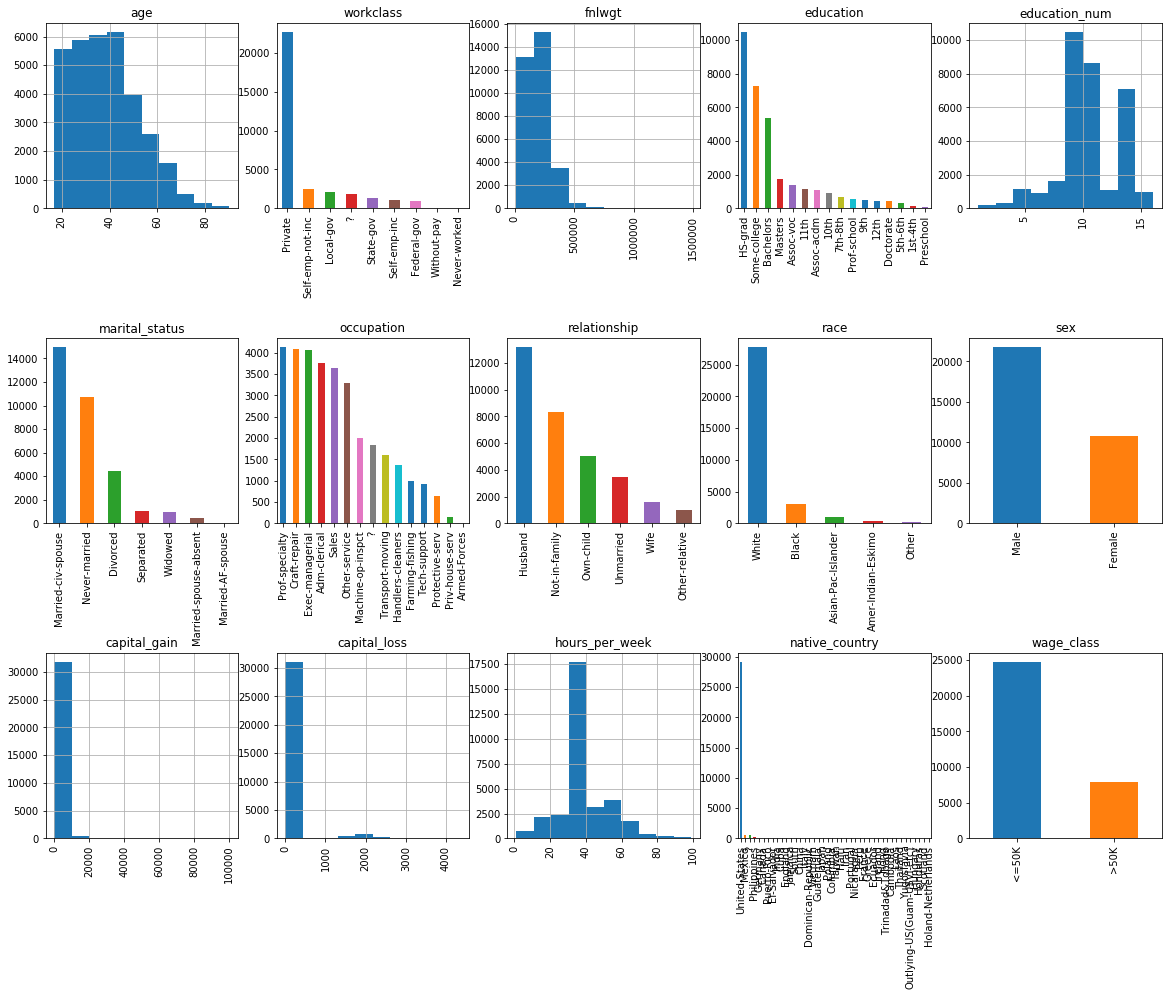

In [11]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = 3
for i, column in enumerate(Train_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if Train_data.dtypes[column] == np.object:
        Train_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        Train_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

We can see from the plots above that our data is mostly concentrated in USA with mostly male and white colored

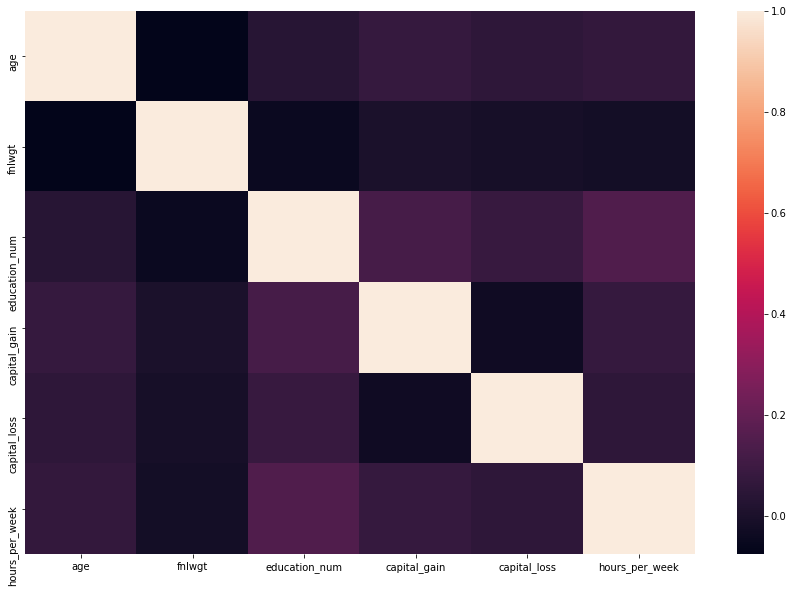

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(Train_data.corr())

There are no missing or null values but replacing all "?" with the string "Unknown"

In [13]:
Train_data.replace('?', 'Unknown', inplace=True)
Test_data.replace('?', 'Unknown', inplace=True)

# Feature: Age, fnlwgt, capital_gain, capital_loss and hours_per_week across Training and Test dataset

Age, fnlwgt, capital_gain, capital_loss and hours_per_week are continuous in nature so those are to be discretized

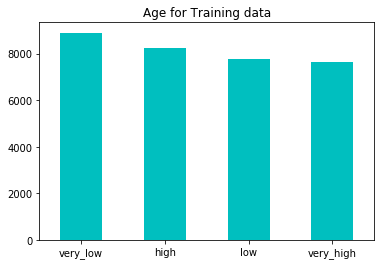

In [14]:
Train_data['Age_Bin'] = pd.qcut(Train_data.age, 4, labels=['very_low','low','high','very_high'])
pd.qcut(Train_data.age, 4, labels=['very_low','low','high','very_high']).value_counts().plot(kind='bar', title='Age for Training data', color='c', rot=0);

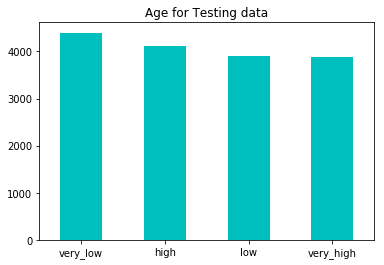

In [15]:
Test_data['Age_Bin'] = pd.qcut(Test_data.age, 4, labels=['very_low','low','high','very_high'])
pd.qcut(Test_data.age, 4, labels=['very_low','low','high','very_high']).value_counts().plot(kind='bar', title='Age for Testing data', color='c', rot=0);

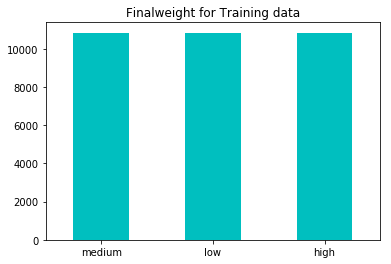

In [16]:
Train_data['Fnlwgt_Bin'] = pd.qcut(Train_data.fnlwgt, 3, labels=['low','medium','high'])
pd.qcut(Train_data.fnlwgt, 3, labels=['low','medium','high']).value_counts().plot(kind='bar', title='Finalweight for Training data', color='c', rot=0);

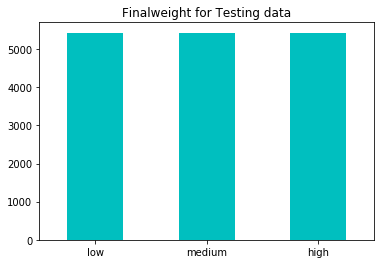

In [17]:
Test_data['Fnlwgt_Bin'] = pd.qcut(Test_data.fnlwgt, 3, labels=['low','medium','high'])
pd.qcut(Test_data.fnlwgt, 3, labels=['low','medium','high']).value_counts().plot(kind='bar', title='Finalweight for Testing data', color='c', rot=0);

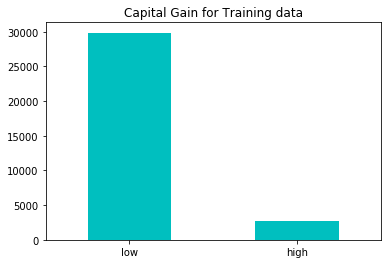

In [20]:
cap_gain = Train_data['capital_gain']
Train_data['Capital_gain_Bin'] = list(map(lambda cap_gain:"low" if(cap_gain==0) else "high", cap_gain))
Train_data.Capital_gain_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Gain for Training data', color='c');

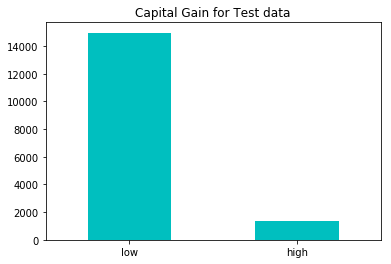

In [21]:
cap_gain = Test_data['capital_gain']
Test_data['Capital_gain_Bin'] = list(map(lambda cap_gain:"low" if(cap_gain==0) else "high", cap_gain))
Test_data.Capital_gain_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Gain for Test data', color='c');

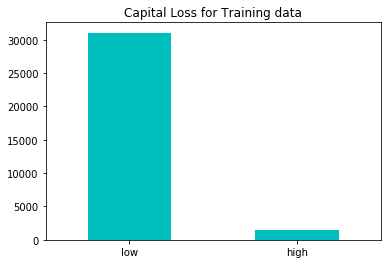

In [22]:
cap_loss = Train_data['capital_loss']
Train_data['Capital_loss_Bin'] = list(map(lambda cap_loss:"low" if(cap_loss==0) else "high", cap_loss))
Train_data.Capital_loss_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Loss for Training data', color='c');

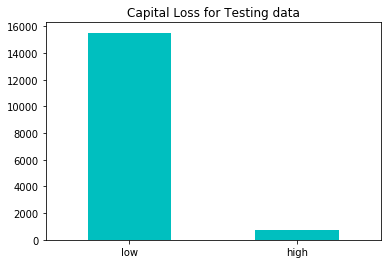

In [23]:
cap_loss = Test_data['capital_loss']
Test_data['Capital_loss_Bin'] = list(map(lambda cap_loss:"low" if(cap_loss==0) else "high", cap_loss))
Test_data.Capital_loss_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Loss for Testing data', color='c');

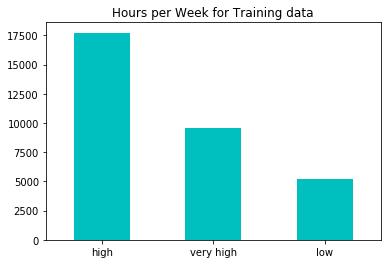

In [24]:
hpw = Train_data['hours_per_week']
Train_data['Hours_per_week_Bin'] = list(map(lambda hpw:"low" if(hpw<=30) else "high" if (hpw>30 and hpw<=40) else "very high", hpw))
Train_data.Hours_per_week_Bin.value_counts().plot(kind='bar',rot = 0, title='Hours per Week for Training data', color='c');

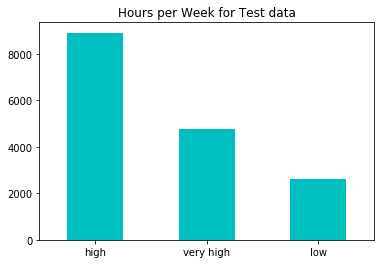

In [25]:
hpw = Test_data['hours_per_week']
Test_data['Hours_per_week_Bin'] = list(map(lambda hpw:"low" if(hpw<=30) else "high" if (hpw>30 and hpw<=40) else "very high", hpw))
Test_data.Hours_per_week_Bin.value_counts().plot(kind='bar',rot = 0, title='Hours per Week for Test data', color='c');

# One Hot Encoding for Feature Age, fnlwgt, capital_gain, capital_loss and hours_per_week across Training and Test dataset

In [26]:
Train_dummies_age_bin = pd.get_dummies(Train_data.Age_Bin, drop_first=True, prefix='Age')
Train_dummies_fnlwgt_bin = pd.get_dummies(Train_data.Fnlwgt_Bin, drop_first=True, prefix='Fnlwgt')
Train_dummies_capital_gain_bin = pd.get_dummies(Train_data.Capital_gain_Bin, drop_first=True, prefix='Capital_gain')
Train_dummies_capital_loss_bin = pd.get_dummies(Train_data.Capital_loss_Bin, drop_first=True, prefix='Capital_loss')
Train_dummies_hours_per_week_bin = pd.get_dummies(Train_data.Hours_per_week_Bin, drop_first=True, prefix='Hours_per_week')

In [27]:
Train_data = Train_data.join([Train_dummies_age_bin,Train_dummies_fnlwgt_bin,Train_dummies_capital_gain_bin,Train_dummies_capital_loss_bin,Train_dummies_hours_per_week_bin])

In [28]:
Train_data = Train_data.drop(['age','Age_Bin','fnlwgt','Fnlwgt_Bin','capital_gain','Capital_gain_Bin','capital_loss','Capital_loss_Bin','hours_per_week','Hours_per_week_Bin'],axis=1)

In [29]:
Train_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,native_country,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,0,1,0,0,0,0,1,0,0
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,0,0,1,0,0,1,1,1,0
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K,0,1,0,0,1,1,1,0,0
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K,0,0,1,0,1,1,1,0,0
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K,0,0,0,0,1,1,1,0,0


In [30]:
Test_dummies_age_bin = pd.get_dummies(Test_data.Age_Bin, drop_first=True, prefix='Age')
Test_dummies_fnlwgt_bin = pd.get_dummies(Test_data.Fnlwgt_Bin, drop_first=True, prefix='Fnlwgt')
Test_dummies_capital_gain_bin = pd.get_dummies(Test_data.Capital_gain_Bin, drop_first=True, prefix='Capital_gain')
Test_dummies_capital_loss_bin = pd.get_dummies(Test_data.Capital_loss_Bin, drop_first=True, prefix='Capital_loss')
Test_dummies_hours_per_week_bin = pd.get_dummies(Test_data.Hours_per_week_Bin, drop_first=True, prefix='Hours_per_week')

In [31]:
Test_data = Test_data.join([Test_dummies_age_bin,Test_dummies_fnlwgt_bin,Test_dummies_capital_gain_bin,Test_dummies_capital_loss_bin,Test_dummies_hours_per_week_bin])

In [32]:
Test_data = Test_data.drop(['age','Age_Bin','fnlwgt','Fnlwgt_Bin','capital_gain','Capital_gain_Bin','capital_loss','Capital_loss_Bin','hours_per_week','Hours_per_week_Bin'],axis=1)

In [33]:
Test_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,native_country,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high
0,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K.,0,0,0,0,1,1,1,0,0
1,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K.,0,1,0,0,0,1,1,0,1
2,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K.,0,0,0,0,1,1,1,0,0
3,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K.,0,1,0,1,0,0,1,0,0
4,Unknown,Some-college,10,Never-married,Unknown,Own-child,White,Female,United-States,<=50K.,0,0,0,0,0,1,1,1,0


# Feature : native_country across Training and Test dataset

There are 42 countries in total, so it's better if we transform the feature by bucketing them across continent and drop native_country column itself

In [34]:
categories_dict = {"United-States":"North America","Mexico":"North America","Unknown":"Unknown","Philippines":"Asia","Germany":"Europe","Canada":"North America","Puerto-Rico":"Central America","El-Salvador":"Central America","India":"Asia","Cuba":"Central America","England":"Europe","Jamaica":"Central America","South":"Asia","China":"Asia","Italy":"Europe","Dominican-Republic":"Central America","Vietnam":"Asia","Guatemala":"Central America","Japan":"Asia","Poland":"Europe","Columbia":"South America","Taiwan":"Asia",
"Haiti":"Central America","Iran":"Asia","Portugal":"Europe","Nicaragua":"Central America","Peru":"South America","Greece":"Europe","France":"Europe","Ecuador":"South America","Ireland":"Europe","Hong":"Asia","Cambodia":"Asia","Trinadad&Tobago":"Central America","Laos":"Asia","Thailand":"Asia","Yugoslavia":"Europe","Outlying-US(Guam-USVI-etc)":"North America","Honduras":"Central America","Hungary":"Europe","Scotland":"Europe","Holand-Netherlands":"Europe"}
Train_data['Continent'] = Train_data['native_country'].map(categories_dict)
Test_data['Continent'] = Test_data['native_country'].map(categories_dict)

In [35]:
Train_data = Train_data.drop(['native_country'],axis=1)
Test_data = Test_data.drop(['native_country'],axis=1)

In [36]:
Train_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,<=50K,0,1,0,0,0,0,1,0,0,North America
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,<=50K,0,0,1,0,0,1,1,1,0,North America
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,<=50K,0,1,0,0,1,1,1,0,0,North America
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,<=50K,0,0,1,0,1,1,1,0,0,North America
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,<=50K,0,0,0,0,1,1,1,0,0,Central America


In [37]:
Test_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent
0,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,<=50K.,0,0,0,0,1,1,1,0,0,North America
1,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,<=50K.,0,1,0,0,0,1,1,0,1,North America
2,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,>50K.,0,0,0,0,1,1,1,0,0,North America
3,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,>50K.,0,1,0,1,0,0,1,0,0,North America
4,Unknown,Some-college,10,Never-married,Unknown,Own-child,White,Female,<=50K.,0,0,0,0,0,1,1,1,0,North America


# One Hot Encoding for Feature native_country across Training and Test dataset

In [38]:
Train_dummies_native_country = pd.get_dummies(Train_data.Continent, drop_first=True, prefix='Continent')
Test_dummies_native_country = pd.get_dummies(Test_data.Continent, drop_first=True, prefix='Continent')

In [39]:
Train_data = Train_data.join(Train_dummies_native_country)
Test_data = Test_data.join(Test_dummies_native_country)

In [40]:
Train_data = Train_data.drop(['Continent'],axis=1)
Test_data = Test_data.drop(['Continent'],axis=1)

# Feature : education and education_num both represent the same information across Training and Test dataset

education and education_num leading to multicollinearity. So, let us drop column education_num

In [41]:
Train_data.education.value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [42]:
Train_data.education_num.value_counts()

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education_num, dtype: int64

In [43]:
Train_data.drop(['education_num'], axis=1, inplace=True)

In [44]:
Test_data.education.value_counts()

HS-grad         5283
Some-college    3587
Bachelors       2670
Masters          934
Assoc-voc        679
11th             637
Assoc-acdm       534
10th             456
7th-8th          309
Prof-school      258
9th              242
12th             224
Doctorate        181
5th-6th          176
1st-4th           79
Preschool         32
Name: education, dtype: int64

In [45]:
Test_data.education_num.value_counts()

9     5283
10    3587
13    2670
14     934
11     679
7      637
12     534
6      456
4      309
15     258
5      242
8      224
16     181
3      176
2       79
1       32
Name: education_num, dtype: int64

In [46]:
Test_data.drop(['education_num'], axis=1, inplace=True)

In [47]:
Train_data.head()

,workclass,education,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent_Central America,Continent_Europe,Continent_North America,Continent_South America,Continent_Unknown
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,<=50K,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,<=50K,0,0,1,0,0,1,1,1,0,0,0,1,0,0
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,<=50K,0,1,0,0,1,1,1,0,0,0,0,1,0,0
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,<=50K,0,0,1,0,1,1,1,0,0,0,0,1,0,0
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,<=50K,0,0,0,0,1,1,1,0,0,1,0,0,0,0


In [48]:
Test_data.head()

,workclass,education,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent_Central America,Continent_Europe,Continent_North America,Continent_South America,Continent_Unknown
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,<=50K.,0,0,0,0,1,1,1,0,0,0,0,1,0,0
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,<=50K.,0,1,0,0,0,1,1,0,1,0,0,1,0,0
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,>50K.,0,0,0,0,1,1,1,0,0,0,0,1,0,0
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,>50K.,0,1,0,1,0,0,1,0,0,0,0,1,0,0
4,Unknown,Some-college,Never-married,Unknown,Own-child,White,Female,<=50K.,0,0,0,0,0,1,1,1,0,0,0,1,0,0


# One Hot Encoding for Features: workclass,education,marital_status,occupation,relationship,race,sex across Training and Test dataset

In [49]:
Train_data = pd.get_dummies(Train_data,columns=['workclass','education','marital_status','occupation','relationship','race','sex'],drop_first=True)
Test_data = pd.get_dummies(Test_data,columns=['workclass','education','marital_status','occupation','relationship','race','sex'],drop_first=True)

In Training dataset the values are <=50K and >50k whereas in Testing dataset the values are <=50K. and >50k. These string values need to be transformed as classfier value as 0 and 1. 0 and 1 states <=50k and >50k respectively

In [50]:
Train_data['wage_class'] = Train_data['wage_class'].map({'<=50K':0,'>50K':1})
Test_data['wage_class'] = Test_data['wage_class'].map({'<=50K.':0,'>50K.':1})
Train_data.head()

,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent_Central America,Continent_Europe,Continent_North America,Continent_South America,Continent_Unknown,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
3,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [51]:
y_Train = Train_data.iloc[:,0]
X_Train = Train_data.iloc[:,1:]

In [52]:
y_Test = Test_data.iloc[:,0]
X_Test = Test_data.iloc[:,1:]

# XG Boost Classifier

Let's go ahead and run XGB on the entire data set, and see how accurate it is!

In [54]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_Train,label=y_Train)
xg_class = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
xg_class.fit(X_Train,y_Train)
predicted = xg_class.predict(X_Test)
accuracy = metrics.accuracy_score(y_Test, predicted)
print("Accuracy is %.2f%%" % (accuracy * 100.0))

C:\Users\WIN7\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\WIN7\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Accuracy is 85.04%


So, the accuracy score using XGB Classifier is 85.04% which is pretty good.